# Echopy: NASC - Nautical Area Scattering Coefficient - $m^2 nmi^{-2}$


In [1]:
import os
import subprocess
from typing import List, Optional, Union, Tuple

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

import echopype as ep
from echopype.testing import TEST_DATA_FOLDER
import echopype.utils

import os
import subprocess
from pathlib import Path
import pytest
import ipytest

import echopype as ep
import echopype.visualize as epviz
from echopype import open_raw
from echopype.calibrate import compute_Sv
from echopype.commongrid import compute_NASC
from echopype.commongrid.nasc import (
    get_distance_from_latlon,
    get_depth_bin_info,
    get_dist_bin_info,
)
from echopype.consolidate import add_location, add_depth
from echopype.testing import TEST_DATA_FOLDER


---------

**Sv2NASC() echopy function**

In [2]:
def Sv2NASC(Sv, r, r0, r1, operation='mean'):
    """
    Compute Nautical Area Scattering Soefficient (m2 nmi-2), by integrating Sv
    in a given range interval.
    
    Parameters
    ----------
        Sv (float)    : 2D array with Sv data (dB m-1)
        r  (float)    : 1D array with range data (m)
        r0 (int/float): Top range limit (m)
        r1 (int/float): Bottom range limit (m)
        method (str)  : Method for calculating NASC. Accepts "mean" or "sum"
        
    Returns
    -------
        float: 1D array with Nautical Area Scattering Coefficient data.
        float: 1D array with the percentage of vertical samples integrated.
    """
   
    # get r0 and r1 indexes
    r0 = np.argmin(abs(r-r0))
    r1 = np.argmin(abs(r-r1))
    
    # get number and height of samples 
    ns     = len(r[r0:r1])
    sh = np.r_[np.diff(r), np.nan]
    sh = np.tile(sh.reshape(-1,1), (1,len(Sv[0])))[r0:r1,:]
    
    # compute NASC    
    sv = echopype.utils.mask_transformation.lin(Sv[r0:r1, :])
    if operation=='mean':    
        NASC = np.nanmean(sv * sh, axis=0) * ns * 4*np.pi*1852**2
    elif operation=='sum':
        NASC = np.nansum (sv * sh, axis=0)      * 4*np.pi*1852**2
    else:
        raise Exception('Method not recognised')
    
    # compute percentage of valid values (not NAN) behind every NASC integration    
    per = (len(sv) - np.sum(np.isnan(sv*sh), axis=0)) / len(sv) * 100
    
    # correct NASC with the proportion of valid values
    NASC = NASC/(per/100)
        
    return NASC, per

---------------

**Test Sv2NASC() using mock data**

In [3]:
# Creating a mock data
data = np.array([
        [1.0, 2.0, 3.0, 4.0, np.nan],
        [6.0, 7.0, 8.0, 9.0, 10.0],
        [11.0, 12.0, 13.0, 14.0, 15.0],
        [16.0, 17.0, 18.0, 19.0, np.nan],
        [21.0, 22.0, 23.0, 24.0, 25.0],
    ])
data = echopype.utils.mask_transformation.log(data)
# example dimension
dim = np.array([0.5, 1.5, 2.5, 3.5, 9])

r = dim
Sv = data
r0=2
r1=20
NASC, per = Sv2NASC(Sv, r, r0, r1, operation='sum')

display(NASC)
display(per)

array([4.52565171e+09, 4.84891254e+09, 5.17217338e+09, 5.49543422e+09,
       1.61630418e+09])

array([100.        , 100.        , 100.        , 100.        ,
        66.66666667])

In [4]:
def test_Sv2NASC():
    # Mock data
    data = np.array([
        [1.0, 2.0, 3.0, 4.0, np.nan],
        [6.0, 7.0, 8.0, 9.0, 10.0],
        [11.0, 12.0, 13.0, 14.0, 15.0],
        [16.0, 17.0, 18.0, 19.0, np.nan],
        [21.0, 22.0, 23.0, 24.0, 25.0],
    ])
    data = echopype.utils.mask_transformation.log(data)
    dim = np.array([0.5, 1.5, 2.5, 3.5, 9])
    r = dim
    Sv = data
    r0 = 2
    r1 = 20
    NASC, per = Sv2NASC(Sv, r, r0, r1, operation='sum')

    # Expected outputs
    expected_NASC = np.array([4.52565171e+09, 4.84891254e+09, 5.17217338e+09, 5.49543422e+09, 1.61630418e+09])
    expected_per = np.array([100., 100., 100., 100., 66.66666667])

    assert np.allclose(NASC, expected_NASC, rtol=1e-5), f"Expected {expected_NASC} but got {NASC}"
    assert np.allclose(per, expected_per, rtol=1e-5), f"Expected {expected_per} but got {per}"


test_Sv2NASC()

______

**Read and clean some real test data**

In [5]:
# The code below ensures that test data is locally available by downloading it from the specified FTP server 
# if it isn't found in the 'echopype/echopype/test_data' directory.

#After ensuring the data is available, the code processes the raw sonar data to obtain 
# the Volume Backscattering Strength (source_Sv) for analysis.

#A specific sonar frequency channel (desired_channel) is also defined for potential impulse noise mask identification.


file_name =  'JR230-D20091215-T121917.raw'
ftp_main = "ftp://ftp.bas.ac.uk"
ftp_partial_path = "/rapidkrill/ek60/"

test_data_path: str = os.path.join(
    TEST_DATA_FOLDER,
    file_name,
)
    

def set_up():
    "Gets the test data if it doesn't already exist"
    if not os.path.exists(TEST_DATA_FOLDER):
        os.mkdir(TEST_DATA_FOLDER)
    if not os.path.exists(test_data_path):
        ftp_file_path = ftp_main + ftp_partial_path + file_name
        subprocess.run(["wget", ftp_file_path, "-O", test_data_path])
        
        
def get_sv_dataset(file_path: str) -> xr.DataArray:
    set_up()
    ed = ep.open_raw(file_path, sonar_model="ek60")
    Sv = ep.calibrate.compute_Sv(ed).compute()
    return Sv, ed


source_Sv, ed = get_sv_dataset(test_data_path)
desired_channel = 'GPT  38 kHz 009072033fa5 1 ES38'

In [6]:
# Add depth param
# If we use depth
from echopype.consolidate import add_depth

ds_Sv = source_Sv.copy()
ds_Sv = add_depth(ds_Sv)
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 572,
                                    range_sample: 3782, filenames: 1, time3: 572)
Coordinates:
  * channel                        (channel) object 'GPT  38 kHz 009072033fa5...
  * ping_time                      (ping_time) datetime64[ns] 2009-12-15T12:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 3779 3780 3781
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2009-12-15T12:19:16...
Data variables: (12/17)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 1.446e+03 ......
    sound_absorption               (channel, ping_time) float64 0.00972 ... 0...
    sa_correction                  (ping_time, channel) float64 -0.63 ... -0.31
    ...                             ...
    angle_sensitivity_athwartship  (channel, ping_time) float64 22.0 ... 23.0
    beamwidth_alongship            (channel, ping_time) float64 7.0 7.0 ... 6.44
    beamwidth_athwartship          (channel, ping_time) float64 7.1 7.1 ... 6.43
    source_filenames               (filenames) <U118 '/Users/simedroniraluca/...
    water_level                    (channel, time3) float64 0.0 0.0 ... 0.0 0.0
    depth                          (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-09-01T14:50:37Z
    processing_function:          calibrate.compute_Sv

In [7]:
# Obtain the Sv without impulse noise.
# 1. Generate an impulse noise mask using the "ryan" method with the specified parameters.
# 2. Apply this mask to the source_Sv to filter out impulse noise.


mask = echopype.mask.get_impulse_noise_mask(ds_Sv, desired_channel, thr=10, m=5, n=1, method="ryan")
Sv_in = echopype.mask.apply_mask(
    ds_Sv,
    mask
) 

Sv_in

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 572,
                                    range_sample: 3782, filenames: 1, time3: 572)
Coordinates:
  * channel                        (channel) object 'GPT  38 kHz 009072033fa5...
  * ping_time                      (ping_time) datetime64[ns] 2009-12-15T12:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 3779 3780 3781
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2009-12-15T12:19:16...
Data variables: (12/17)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 1.446e+03 ......
    sound_absorption               (channel, ping_time) float64 0.00972 ... 0...
    sa_correction                  (ping_time, channel) float64 -0.63 ... -0.31
    ...                             ...
    angle_sensitivity_athwartship  (channel, ping_time) float64 22.0 ... 23.0
    beamwidth_alongship            (channel, ping_time) float64 7.0 7.0 ... 6.44
    beamwidth_athwartship          (channel, ping_time) float64 7.1 7.1 ... 6.43
    source_filenames               (filenames) <U118 '/Users/simedroniraluca/...
    water_level                    (channel, time3) float64 0.0 0.0 ... 0.0 0.0
    depth                          (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-09-01T14:50:37Z
    processing_function:          calibrate.compute_Sv
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2285+g595ff46
    mask_time:                    2023-09-01T14:50:37Z
    mask_function:                mask.apply_mask

---------

**Provide find_Sv2NASC_for_all_channels() function to make Sv2NASC() compatible with echopype (for all channels)**

In [8]:
def find_Sv2NASC_for_all_channels(Sv_ds: xr.Dataset, r0: float, r1: float, operation='mean') -> xr.Dataset:
    
    """
    Calculate the Nautical Area Scattering Coefficient (NASC) and the percentage of samples integrated (NASC_per) 
    for each channel within the provided Sv_ds dataset. 
    The calculation is performed for a given range interval.

    Parameters
    ----------
    Sv_ds : xr.Dataset
        The dataset containing Sv data. It must have the `channel` and `ping_time` coordinates 
        and relevant data variables: `Sv` and `echo_range`.
    r0 : float
        The top range limit (in meters) for the depth integration.
    r1 : float
        The bottom range limit (in meters) for the depth integration.
    operation : str, optional
        The method of calculating NASC. Accepts either "mean" or "sum". Defaults to "mean".

    Returns
    -------
    xr.Dataset
        The input dataset augmented with two new data variables: 'Sv2NASC' and 'Sv2NASC_per'.
        Both data variables have two dimensions: 'channel' and 'ping_time'.

    """

    # Get all unique channels in the Dataset
    channels = Sv_ds['channel'].values

    all_NASC = []
    all_NASCper = []

    for channel in channels:

        Sv = Sv_ds['Sv'].sel(channel=channel).values  # Extract numpy array from xarray.DataArray
        ping_time = Sv_ds['ping_time'].values
        # Check Sv contains depth
        if 'depth' not in list(Sv_ds.data_vars.keys()):
            warnings.warn("'depth' does not exist in the input Sv dataset. "
                  "'echo_range' was used as a substitute. "
                  "However, if 'echo_range' and 'depth' are not identical, "
                  "the obtained values might differ from the expected ones.", UserWarning)
            
            echo_range = Sv_ds['echo_range'].sel(channel=channel).values[1,:]
            NASC, NASCper = Sv2NASC(Sv.T, echo_range, r0, r1, operation=operation)
        else:
            depth = Sv_ds['depth'].sel(channel=channel).values[1,:] 
            NASC, NASCper = Sv2NASC(Sv.T, depth, r0, r1, operation=operation)
        
        # Store results in lists
        all_NASC.append(NASC)
        all_NASCper.append(NASCper)

    # Convert lists to numpy arrays
    all_NASC = np.array(all_NASC)
    all_NASCper = np.array(all_NASCper)

    # Add Sv2NASC and Sv2NASC_per as new data variables to the existing Sv_ds
    Sv_ds['Sv2NASC'] = xr.DataArray(
        all_NASC,
        dims=("channel", "ping_time"),
        coords={"channel": channels, "ping_time": ping_time}
    )

    Sv_ds['Sv2NASC_per'] = xr.DataArray(
        all_NASCper,
        dims=("channel", "ping_time"),
        coords={"channel": channels, "ping_time": ping_time}
    )
    
    return Sv_ds


**Apply find_Sv2NASC_for_all_channels() to data free of impulse noise and with depth variable present**

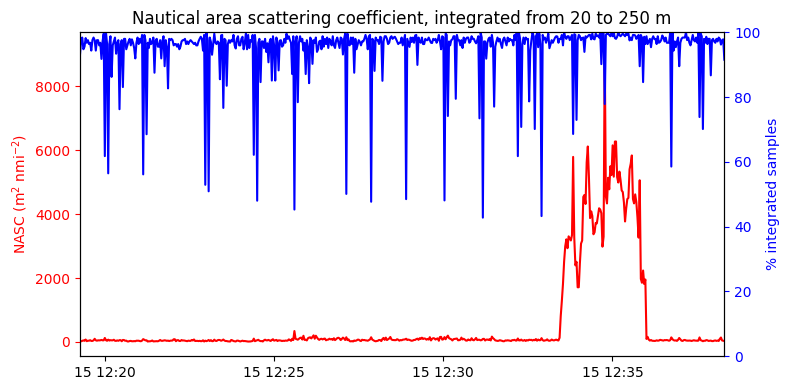

In [9]:
Sv_NASC = find_Sv2NASC_for_all_channels(Sv_in, 20, 250, operation='sum')

t38 = Sv_NASC['ping_time'].values
NASC =   Sv_NASC['Sv2NASC'].sel(channel=desired_channel).values  
NASCper =  Sv_NASC['Sv2NASC_per'].sel(channel=desired_channel).values  

# Create a figure and subplot.
fig, ax1 = plt.subplots(figsize=(8,4))

# Plot NASC on the primary y-axis.
ax1.plot(t38, NASC, '-r')
ax1.set_xlim(t38[0], t38[-1])
ax1.tick_params(axis='y', colors='r')
ax1.set_ylabel('NASC (m$^2$ nmi$^{-2}$)', color='r')

# Create a twin y-axis for NASCper.
ax2 = ax1.twinx()
ax2.plot(t38, NASCper, '-b')
ax2.set_xlim(t38[0], t38[-1])
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', colors='b')
ax2.set_ylabel('% integrated samples', color='b')

# Set the title.
ax2.set_title('Nautical area scattering coefficient, integrated from 20 to 250 m')

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()

**Apply find_Sv2NASC_for_all_channels() to data free of impulse noise and with depth variable not present**

/var/folders/k4/lbgk719n1yd1z7f420ftycl00000gn/T/ipykernel_36303/3345690292.py:40: UserWarning: 'depth' does not exist in the input Sv dataset. 'echo_range' was used as a substitute. However, if 'echo_range' and 'depth' are not identical, the obtained values might differ from the expected ones.
  warnings.warn("'depth' does not exist in the input Sv dataset. "


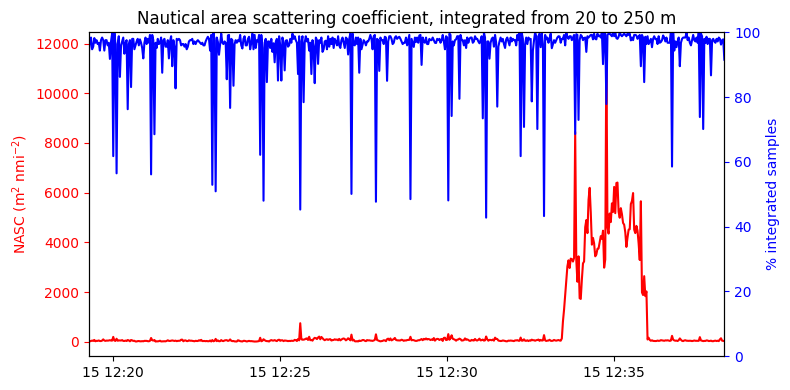

In [10]:
import warnings


# The code below ensures that test data is locally available by downloading it from the specified FTP server 
# if it isn't found in the 'echopype/echopype/test_data' directory.

#After ensuring the data is available, the code processes the raw sonar data to obtain 
# the Volume Backscattering Strength (source_Sv) for analysis.

#A specific sonar frequency channel (desired_channel) is also defined for potential impulse noise mask identification.


file_name =  'JR230-D20091215-T121917.raw'
ftp_main = "ftp://ftp.bas.ac.uk"
ftp_partial_path = "/rapidkrill/ek60/"

test_data_path: str = os.path.join(
    TEST_DATA_FOLDER,
    file_name,
)
    

def set_up():
    "Gets the test data if it doesn't already exist"
    if not os.path.exists(TEST_DATA_FOLDER):
        os.mkdir(TEST_DATA_FOLDER)
    if not os.path.exists(test_data_path):
        ftp_file_path = ftp_main + ftp_partial_path + file_name
        subprocess.run(["wget", ftp_file_path, "-O", test_data_path])
        
        
def get_sv_dataset(file_path: str) -> xr.DataArray:
    set_up()
    ed = ep.open_raw(file_path, sonar_model="ek60")
    Sv = ep.calibrate.compute_Sv(ed).compute()
    return Sv, ed


source_Sv, ed = get_sv_dataset(test_data_path)
desired_channel = 'GPT  38 kHz 009072033fa5 1 ES38'

# Obtain the Sv without impulse noise.
# 1. Generate an impulse noise mask using the "ryan" method with the specified parameters.
# 2. Apply this mask to the source_Sv to filter out impulse noise.


#if we use echo_range:
mask = echopype.mask.get_impulse_noise_mask(source_Sv, desired_channel, thr=10, m=5, n=1, method="ryan")
Sv_in = echopype.mask.apply_mask(
        source_Sv,
        mask
    ) 

Sv_in

Sv_NASC = find_Sv2NASC_for_all_channels(Sv_in, 20, 250, operation='mean')

t38 = Sv_NASC['ping_time'].values
NASC =   Sv_NASC['Sv2NASC'].sel(channel=desired_channel).values  
NASCper =  Sv_NASC['Sv2NASC_per'].sel(channel=desired_channel).values  

# Create a figure and subplot.
fig, ax1 = plt.subplots(figsize=(8,4))

# Plot NASC on the primary y-axis.
ax1.plot(t38, NASC, '-r')
ax1.set_xlim(t38[0], t38[-1])
ax1.tick_params(axis='y', colors='r')
ax1.set_ylabel('NASC (m$^2$ nmi$^{-2}$)', color='r')

# Create a twin y-axis for NASCper.
ax2 = ax1.twinx()
ax2.plot(t38, NASCper, '-b')
ax2.set_xlim(t38[0], t38[-1])
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', colors='b')
ax2.set_ylabel('% integrated samples', color='b')

# Set the title.
ax2.set_title('Nautical area scattering coefficient, integrated from 20 to 250 m')

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()


**Read new set of test data. Apply find_Sv2NASC_for_all_channels() to data with depth variable present**

In [11]:
bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170620-T011027.raw"
s3raw_fpath = f"s3://{bucket}/{rawdirpath}"
ed = ep.open_raw(s3raw_fpath, sonar_model='EK60', storage_options={'anon': True})
# Manually populate additional metadata about the dataset and the platform
# -- SONAR-netCDF4 Top-level Group attributes
ed['Top-level'].attrs['title'] = "2017 Pacific Hake Acoustic Trawl Survey"
ed['Top-level'].attrs['summary'] = (
    f"EK60 raw file {s3raw_fpath} from the {ed['Top-level'].attrs['title']}, "
    "converted to a SONAR-netCDF4 file using echopype."
)
# -- SONAR-netCDF4 Platform Group attributes
ed['Platform'].attrs['platform_type'] = "Research vessel"
ed['Platform'].attrs['platform_name'] = "Bell M. Shimada"
ed['Platform'].attrs['platform_code_ICES'] = "315"

ds_Sv = add_depth(add_location(compute_Sv(ed), ed, nmea_sentence="GGA"))
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 1932,
                                    range_sample: 1055, filenames: 1,
                                    time3: 1932)
Coordinates:
  * channel                        (channel) object 'GPT  18 kHz 009072058c8d...
  * ping_time                      (ping_time) datetime64[ns] 2017-06-20T01:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 1052 1053 1054
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2017-06-20T01:10:27...
Data variables: (12/19)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 1.481e+03 ......
    sound_absorption               (channel, ping_time) float64 0.002822 ... ...
    sa_correction                  (ping_time, channel) float64 -0.83 ... -0.34
    ...                             ...
    beamwidth_athwartship          (channel, ping_time) float64 10.3 ... 7.2
    source_filenames               (filenames) <U92 's3://ncei-wcsd-archive/d...
    water_level                    (channel, time3) float64 9.15 9.15 ... 9.15
    latitude                       (ping_time) float64 nan 44.71 ... 44.7 44.7
    longitude                      (ping_time) float64 nan -124.3 ... -124.4
    depth                          (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-09-01T14:50:50Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [12]:
ds_Sv['depth']

<xarray.DataArray 'depth' (channel: 3, ping_time: 1932, range_sample: 1055)>
array([[[0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        ...,
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02]],

       [[0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
...
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02]],

       [[0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        ...,
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
        [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
         1.99375171e+02, 1.99564691e+02, 1.99754211e+02]]])
Coordinates:
  * channel       (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ......
  * ping_time     (ping_time) datetime64[ns] 2017-06-20T01:10:27.136999936 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 1050 1051 1052 1053 1054
Attributes:
    long_name:      Depth
    standard_name:  depth
    units:          m
    history:        2023-09-01 14:50:50.381270 +00:00. Added based on echo_ra...

In [13]:
Sv = find_Sv2NASC_for_all_channels(ds_Sv, 20, 250, operation='mean')

In [14]:
Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 1932,
                                    range_sample: 1055, filenames: 1,
                                    time3: 1932)
Coordinates:
  * channel                        (channel) object 'GPT  18 kHz 009072058c8d...
  * ping_time                      (ping_time) datetime64[ns] 2017-06-20T01:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 1052 1053 1054
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2017-06-20T01:10:27...
Data variables: (12/21)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 1.481e+03 ......
    sound_absorption               (channel, ping_time) float64 0.002822 ... ...
    sa_correction                  (ping_time, channel) float64 -0.83 ... -0.34
    ...                             ...
    water_level                    (channel, time3) float64 9.15 9.15 ... 9.15
    latitude                       (ping_time) float64 nan 44.71 ... 44.7 44.7
    longitude                      (ping_time) float64 nan -124.3 ... -124.4
    depth                          (channel, ping_time, range_sample) float64 ...
    Sv2NASC                        (channel, ping_time) float64 1.361e+07 ......
    Sv2NASC_per                    (channel, ping_time) float64 100.0 ... 100.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-09-01T14:50:50Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [15]:
Sv['Sv2NASC'].values.min()

0.0050594870754597015

In [16]:
Sv['Sv2NASC'].values.max()

128981715.98952511

In [17]:
Sv['Sv2NASC'].sel(channel='GPT 120 kHz 00907205a6d0 4-1 ES120-7C').mean()

<xarray.DataArray 'Sv2NASC' ()>
array(3000663.94156923)
Coordinates:
    channel  <U37 'GPT 120 kHz 00907205a6d0 4-1 ES120-7C'

**Test find_Sv2NASC_for_all_channels()**

```
import math

import numpy as np
import pytest

from echopype import open_raw
from echopype.calibrate import compute_Sv
from echopype.commongrid import compute_NASC
from echopype.commongrid.nasc import get_distance_from_latlon
from echopype.consolidate import add_depth, add_location


@pytest.fixture
def ek60_path(test_path):
    return test_path["EK60"]


def test_compute_NASC(ek60_path):
    raw_path = ek60_path / "ncei-wcsd/Summer2017-D20170620-T011027.raw"

    ed = open_raw(raw_path, sonar_model="EK60")
    ds_Sv = add_depth(add_location(compute_Sv(ed), ed, nmea_sentence="GGA"))
    Sv = find_Sv2NASC_for_all_channels(ds_Sv, 20, 250, operation='mean')
    dist_nmi = get_distance_from_latlon(ds_Sv)

    da_NASC = Sv['Sv2NASC'].values
    decimal_places = 5
    tolerance = 10 ** (-decimal_places)
    nasc_min = da_NASC.min()
    nasc_max = da_NASC.max()
    assert math.isclose(nasc_max, 128981715.98952511, rel_tol=tolerance)
    assert math.isclose(nasc_min, 0.0050594870754597015, rel_tol=tolerance)
    assert math.isclose(nasc_ch_mean, 3000663.94156923, rel_tol=tolerance)
```

In [18]:
import math

import numpy as np
import pytest

from echopype import open_raw
from echopype.calibrate import compute_Sv
from echopype.commongrid import compute_NASC
from echopype.commongrid.nasc import get_distance_from_latlon
from echopype.consolidate import add_depth, add_location


def test_compute_NASC(ds_Sv):

    Sv = find_Sv2NASC_for_all_channels(ds_Sv, 20, 250, operation='mean')
    dist_nmi = get_distance_from_latlon(ds_Sv)

    da_NASC = Sv['Sv2NASC'].values
    decimal_places = 5
    tolerance = 10 ** (-decimal_places)
    nasc_min = da_NASC.min()
    nasc_max = da_NASC.max()
    nasc_ch_mean = Sv['Sv2NASC'].sel(channel='GPT 120 kHz 00907205a6d0 4-1 ES120-7C').mean()
    assert math.isclose(nasc_max, 128981715.98952511, rel_tol=tolerance)
    assert math.isclose(nasc_min, 0.0050594870754597015, rel_tol=tolerance)
    assert math.isclose(nasc_ch_mean, 3000663.94156923, rel_tol=tolerance)
    
test_compute_NASC(ds_Sv)
